# Visão geral dos dados coletados

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import sys


sys.path.append("../../")
sys.path.append("../../odbc")
import query_tools as qt
from connection import load_conn

## Linhas coletadas

### Quantas linhas de informação dos voos foram coletadas?

In [3]:
q = """
SELECT count(*)
FROM flight.search
"""
qt.run_query(q)

,count
0,187872137


### Em média quantas linhas novas são coletadas por dia?
Obs: considerando que o crawler coletaria 24h por dia
Uma boa estimativa é verificar qual a média de linhas coletadas por hora e multiplicar por 24h, vai ser uma estimativa melhor.

In [4]:
# Media e desvio padrao do nº de linhas coletadas por hora
q = """
SELECT AVG(count) AS average_rows_por_hora, stddev(count) AS desvio_padrao_por_hora
FROM (
    SELECT COUNT(*) AS count
    FROM flight.search
    GROUP BY DATE_TRUNC('hour', "operationalSearchTime")
) subquery
"""
metricas_coleta_linhas_por_hora = qt.run_query(q)
metricas_coleta_linhas_por_hora

,average_rows_por_hora,desvio_padrao_por_hora
0,202885.677106,76525.303746


In [5]:
estimativa_linhas_coletadas_por_dia = metricas_coleta_linhas_por_hora.loc[0, "average_rows_por_hora"] * 24
estimativa_linhas_coletadas_por_dia

4869256.250539957

## Memória

### Quantos Bytes tem o banco de dados?

In [6]:
# Consulta para obter o tamanho do banco de dados em bytes
q = "SELECT pg_database_size('flight')"
bytes_df = qt.run_query(q)
bytes_df

,pg_database_size
0,153422136099


### Quantos Gigabytes tem o banco de dados?

In [7]:
bytes_ = bytes_df.loc[0, "pg_database_size"]
# Consulta para obter o tamanho do banco de dados em gigabytes 
q = f"SELECT pg_size_pretty({bytes_})"
qt.run_query(q)

,pg_size_pretty
0,143 GB


## Coleta de dados

### Quais as datas e horários que temos coletados?

In [8]:
q = """
SELECT DISTINCT DATE_TRUNC('hour', "operationalSearchTime") AS "operationalSearchTime"
FROM flight.search
"""

operationalSearchTime = qt.run_query(q)

In [9]:
operationalSearchTime.head(1)

,operationalSearchTime
0,2023-06-04 09:00:00


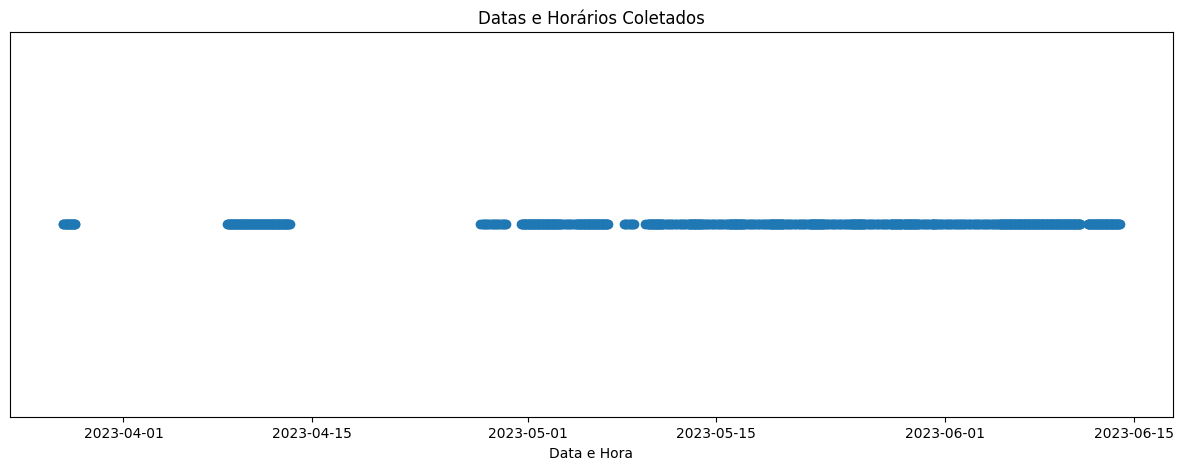

In [10]:
plt.figure(figsize=(15, 5))
plt.scatter(operationalSearchTime['operationalSearchTime'],
            [1] * len(operationalSearchTime))
plt.yticks([])  # Remove os valores no eixo y
plt.xlabel('Data e Hora')
plt.title('Datas e Horários Coletados')
plt.show()


### Qual a quantidade de voos capturados em cada coleta?

In [11]:
q = """
SELECT DISTINCT DATE_TRUNC('hour', "operationalSearchTime") AS hora_coletada,
    count(*) AS linhas_coletadas
FROM flight.search
GROUP BY hora_coletada
"""
coleta = qt.run_query(q)

In [12]:
coleta.hora_coletada.max(), coleta.hora_coletada.min()

(Timestamp('2023-06-13 23:00:00'), Timestamp('2023-03-27 12:00:00'))

In [13]:
coleta.head(10).to_dict()

{'hora_coletada': {0: Timestamp('2023-03-27 12:00:00'),
  1: Timestamp('2023-03-27 13:00:00'),
  2: Timestamp('2023-03-27 14:00:00'),
  3: Timestamp('2023-03-27 16:00:00'),
  4: Timestamp('2023-03-27 17:00:00'),
  5: Timestamp('2023-03-27 18:00:00'),
  6: Timestamp('2023-03-27 19:00:00'),
  7: Timestamp('2023-03-27 20:00:00'),
  8: Timestamp('2023-03-27 21:00:00'),
  9: Timestamp('2023-03-27 22:00:00')},
 'linhas_coletadas': {0: 217728,
  1: 216485,
  2: 191034,
  3: 215153,
  4: 214490,
  5: 193087,
  6: 14274,
  7: 9947,
  8: 6459,
  9: 3868}}

In [14]:
# Definir intervalo de datas completo
start_date = coleta['hora_coletada'].min()
end_date = coleta['hora_coletada'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# Criar DataFrame com todas as horas do intervalo
complete_df = pd.DataFrame({'hora_coletada': date_range})

# Fazer merge dos DataFrames
coleta_completa = pd.merge(complete_df, coleta, on='hora_coletada', how='left')
coleta_completa['linhas_coletadas'] = coleta_completa['linhas_coletadas'].fillna(0)

# Ordenar DataFrame pelo horário
coleta_completa = coleta_completa.sort_values('hora_coletada')


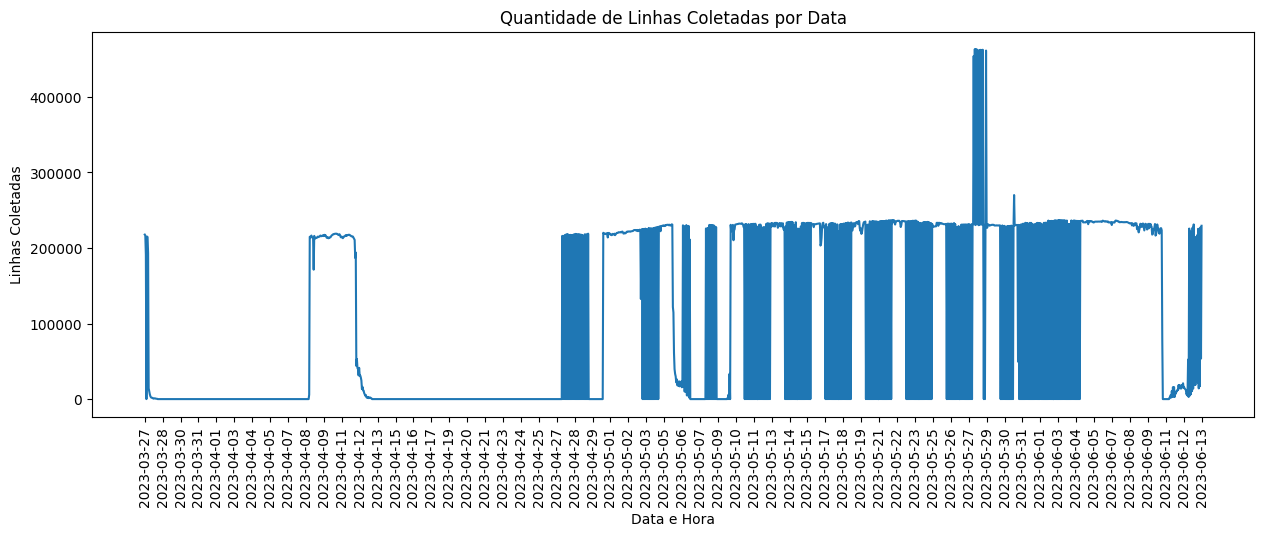

In [15]:
# Criando o gráfico
plt.figure(figsize=(15, 5))
plt.plot(coleta_completa["hora_coletada"], coleta_completa["linhas_coletadas"])
plt.xticks(rotation=90)

# Configurando as datas no eixo x
num_ticks = 60  # Número desejado de ticks no eixo x
date_range = pd.date_range(start=coleta_completa["hora_coletada"].min(), end=coleta_completa["hora_coletada"].max(), periods=num_ticks)
plt.xticks(date_range, rotation=90)

plt.xlabel('Data e Hora')
plt.ylabel('Linhas Coletadas')
plt.title('Quantidade de Linhas Coletadas por Data')
plt.show()


### Qual a maior janela de coleta consecutiva?

In [16]:
coleta_completa.sort_values("hora_coletada", inplace=True, ignore_index=True)
display(coleta_completa.head())

teve_coleta = (coleta_completa.linhas_coletadas != 0).map(int)

,hora_coletada,linhas_coletadas
0,2023-03-27 12:00:00,217728.0
1,2023-03-27 13:00:00,216485.0
2,2023-03-27 14:00:00,191034.0
3,2023-03-27 15:00:00,0.0
4,2023-03-27 16:00:00,215153.0


In [17]:
# Variáveis para acompanhar a sequência atual e a sequência máxima
numero_zeros_aceitaveis = 0
current_sequence = 0
max_sequence = 0
primeiro_valor_sequencia = True
menor_data = None
maior_data = None

contador_zeros = 0

# Percorrer a série
for indice, value in enumerate(teve_coleta):
    if value == 1:
        if primeiro_valor_sequencia:
            menor_data_sequencia_atual = coleta_completa.loc[indice, "hora_coletada"]
            primeiro_valor_sequencia = False

        current_sequence += 1
        contador_zeros = 0
        if current_sequence > max_sequence:
            max_sequence = current_sequence
            menor_data = menor_data_sequencia_atual
            maior_data = coleta_completa.loc[indice, "hora_coletada"]
    else:
        contador_zeros += 1
        
        if contador_zeros > numero_zeros_aceitaveis:
            current_sequence = 0
            primeiro_valor_sequencia = True

print("Maior sequência de 1's:", max_sequence, f"Isso equivale a {round(max_sequence / 24, 2)} dias")
print(f"Data de inicio da sequencia {menor_data} , data do fim da sequencia {maior_data}")

Maior sequência de 1's: 147 Isso equivale a 6.12 dias
Data de inicio da sequencia 2023-06-04 23:00:00 , data do fim da sequencia 2023-06-11 01:00:00


In [18]:
# Conferindo o intervalo encontrado
numero_horas = len(pd.date_range(start=menor_data, end=maior_data, freq='H'))
numero_horas, numero_horas/24

(147, 6.125)

## Voos únicos

### Quantos voos únicos foram coletados?

In [19]:
q = """
SELECT count(*) as voos_unicos
FROM (SELECT DISTINCT "legId" FROM flight.fare) subquery
"""
qt.run_query(q)

,voos_unicos
0,1184020


### Em média quantos voos únicos são coletados por dia?


In [22]:
q = """
SELECT AVG(voos_unicos) as media_voos_unicos
FROM (
    SELECT DATE_TRUNC('day', "operationalSearchTime") as search_day,
        count(*) AS voos_unicos
    FROM (SELECT DISTINCT F."legId", S."operationalSearchTime"
          FROM flight.fare F
          JOIN flight.search S ON F."searchId" = S."searchId"
          ) subquery
    GROUP BY search_day
) subquery2
"""

media_voos_unicos_dia = qt.run_query(q)
media_voos_unicos_dia

,media_voos_unicos
0,3.373279e+06


In [23]:
media_voos_unicos_dia["media_voos_unicos"] = media_voos_unicos_dia["media_voos_unicos"].apply(lambda x: '{:,.2f}'.format(x))
media_voos_unicos_dia
# TEM ALGO MUITO ESTRANHO AQUI, VERIFICAR ISSO

,media_voos_unicos
0,"3,373,279.07"


## Cidade

In [24]:
airport = qt.get_table("airport")
airport = airport[["airportCode", "city"]]

def merge_airport(df, column_merge):
    if isinstance(column_merge, str):
        df = df.merge(airport, how="left", left_on=column_merge, right_on="airportCode")
        del df["airportCode"]
    elif isinstance(column_merge, list):
        for index, column in enumerate(column_merge):
            old_column = "" if index == 0 else column_merge[(index-1)]
            df = df.merge(airport, how="left",
                          left_on=column,
                          right_on="airportCode",
                          suffixes=(old_column, f"_{column}"))
            del df["airportCode"]
    return df

### Quantos voos únicos saem de cada cidade?

In [25]:
q = """
SELECT "originCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "originCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY "originCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_saida = qt.run_query(q)

In [26]:
merge_airport(voos_unicos_saida, "originCode")

,originCode,voos_unicos,city
0,POA,170126,Porto Alegre
1,SSA,164496,Salvador
2,MAO,162586,Manaus
3,BSB,142282,NaN
4,SDU,134209,Rio de Janeiro
5,CNF,125504,NaN
6,CGH,107237,São Paulo
7,GIG,99829,Rio de Janeiro
8,GRU,77751,Guarulhos


### Quantos voos únicos chegam em cada cidade?

In [27]:
q = """
SELECT "destinationCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "destinationCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY "destinationCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_chegada = qt.run_query(q)

In [28]:
voos_unicos_chegada = merge_airport(voos_unicos_chegada, "destinationCode")
voos_unicos_chegada

,destinationCode,voos_unicos,city
0,POA,173604,Porto Alegre
1,MAO,167212,Manaus
2,SSA,160951,Salvador
3,BSB,146537,NaN
4,SDU,128350,Rio de Janeiro
5,CNF,127111,NaN
6,CGH,107606,São Paulo
7,GIG,91415,Rio de Janeiro
8,GRU,81234,Guarulhos


### Quantos voos únicos existem em cada trecho?

In [29]:
q = """
SELECT "originCode", "destinationCode", count(*) as voos_unicos
FROM (
    SELECT DISTINCT "legId", "originCode", "destinationCode"
    FROM flight.fare F
        JOIN flight.search S
        ON S."searchId" = F."searchId" 
) subquery
GROUP BY  "originCode", "destinationCode"
ORDER BY voos_unicos DESC
"""
voos_unicos_trecho = qt.run_query(q)

In [30]:
voos_unicos_trecho = merge_airport(voos_unicos_trecho, ["originCode", "destinationCode"])
voos_unicos_trecho

,originCode,destinationCode,voos_unicos,cityoriginCode,city_destinationCode
0,SSA,POA,32305,Salvador,Porto Alegre
1,POA,SSA,29893,Porto Alegre,Salvador
2,POA,MAO,28810,Porto Alegre,Manaus
3,MAO,POA,28011,Manaus,Porto Alegre
4,MAO,SSA,26218,Manaus,Salvador
...,...,...,...,...,...
63,CNF,GRU,6038,NaN,Guarulhos
64,GRU,GIG,5959,Guarulhos,Rio de Janeiro
65,GRU,CNF,5668,Guarulhos,NaN
66,GIG,CGH,4865,Rio de Janeiro,São Paulo


In [31]:
voos_unicos_trecho[["cityoriginCode", "city_destinationCode", "voos_unicos"]].head(50)

,cityoriginCode,city_destinationCode,voos_unicos
0,Salvador,Porto Alegre,32305
1,Porto Alegre,Salvador,29893
2,Porto Alegre,Manaus,28810
3,Manaus,Porto Alegre,28011
4,Manaus,Salvador,26218
5,Salvador,Manaus,25781
6,Rio de Janeiro,Porto Alegre,23986
7,Rio de Janeiro,Salvador,23867
8,Salvador,NaN,23039
9,Rio de Janeiro,NaN,22668


## Companias aéreas 

### Quais são as companhias aéreas coletadas?

In [32]:
qt.get_table("airline")[["airlineCode", "airlineName"]].drop_duplicates()

,airlineCode,airlineName
0,LA,LATAM Airlines Group
1,G3,GOL Linhas Aereas S.A.
6,H1,Hahn Air Systems


### Quantos voos únicos cada companía fez?

In [33]:
q = """
SELECT "airlineName", count(*) as voos_unicos
FROM (
    SELECT DISTINCT F."legId", A."airlineName"
    FROM flight.flight F
        LEFT JOIN flight.airline A
        ON A."airlineCode" = F."airlineCode"
) subquery
GROUP BY  "airlineName"
ORDER BY voos_unicos DESC
"""
voos_unicos_compania = qt.run_query(q)

In [34]:
voos_unicos_compania

,airlineName,voos_unicos
0,None,1112915
1,LATAM Airlines Group,36835
2,GOL Linhas Aereas S.A.,34270
